In [5]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import r2_score

import data_parser
import MLP


In [2]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

CUDA avaiable


In [3]:
def plot_X_y(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
             figname=None, savefig=False):
    
    # Plot a 3x3 figure
    line = 7
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)

    
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy())
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy())
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)
    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        plt.savefig('../Figures/pdf/'+figname+'.pdf', bbox_inches= 'tight')
        plt.savefig('../Figures/png/'+figname+'.png', bbox_inches= 'tight')
        
    plt.show();

In [4]:
def plot_X_y_train(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
                   figname=None, savefig=False):
    
    # Plot a 3x3 figure
    line = 20
    
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)

    
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy())
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy())
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)

    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        plt.savefig('../Figures/pdf/'+figname+'.pdf', bbox_inches= 'tight')
        plt.savefig('../Figures/png/'+figname+'.png', bbox_inches= 'tight')
        

In [6]:
df = data_parser.calculate_amp_phase(data_parser.data_parse(), unwrap=True)

In [7]:
models = {}
predictions = {}

# Randomly shuffle the indices
index_list = list(dict.fromkeys(df.index.get_level_values(0)))
random.seed(42)
np.random.shuffle(index_list)

# Split the indices into 80% training set, 10% testing set and 10% validation set
indices = {}
indices['train_idx'] = index_list[:int(len(index_list) * 0.8)]
indices['val_idx'] = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
indices['test_idx'] = index_list[int(len(index_list) * 0.9):]

input_cols = ["W", "Trap", "Length"]

in_features = 3
out_features = 501

# Define F for plot
F = torch.Tensor(df.loc[indices['train_idx'][0]]['F']).reshape(-1, 1)

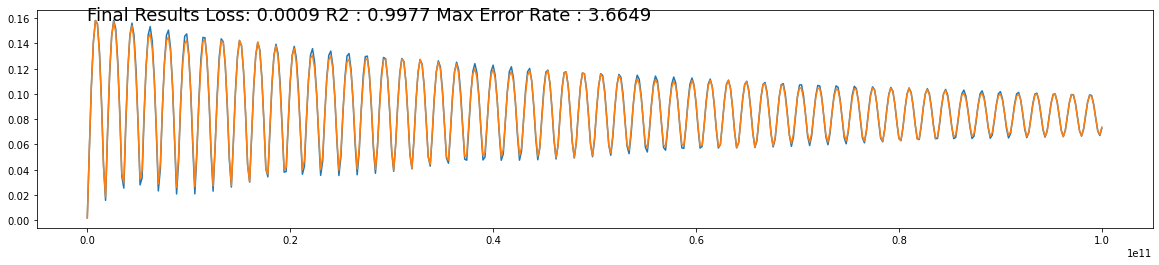

In [8]:
# Train A(1,1)
output_col = 'A(1,1)'
models[output_col] = MLP.Model(df, indices, input_cols, output_col, in_features, out_features, device)
models[output_col].train(0.001, 40000)
predictions[output_col] = models[output_col].test()

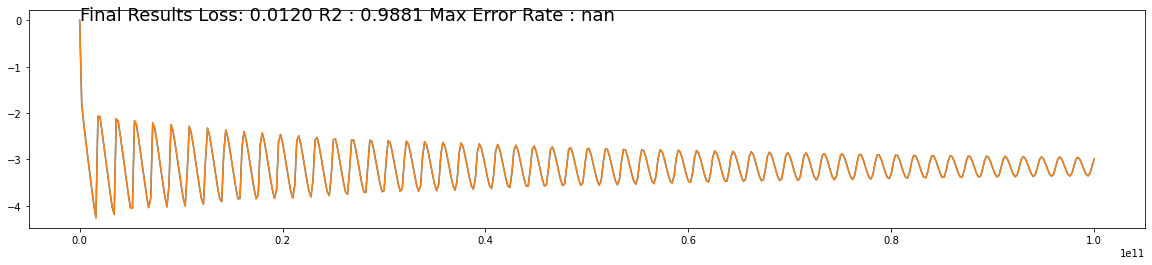

In [9]:
# Train P(1,1)
output_col = 'P(1,1)'
models[output_col] = MLP.Model(df, indices, input_cols, output_col, in_features, out_features, device)
models[output_col].train(0.001, 40000)
predictions[output_col] = models[output_col].test()

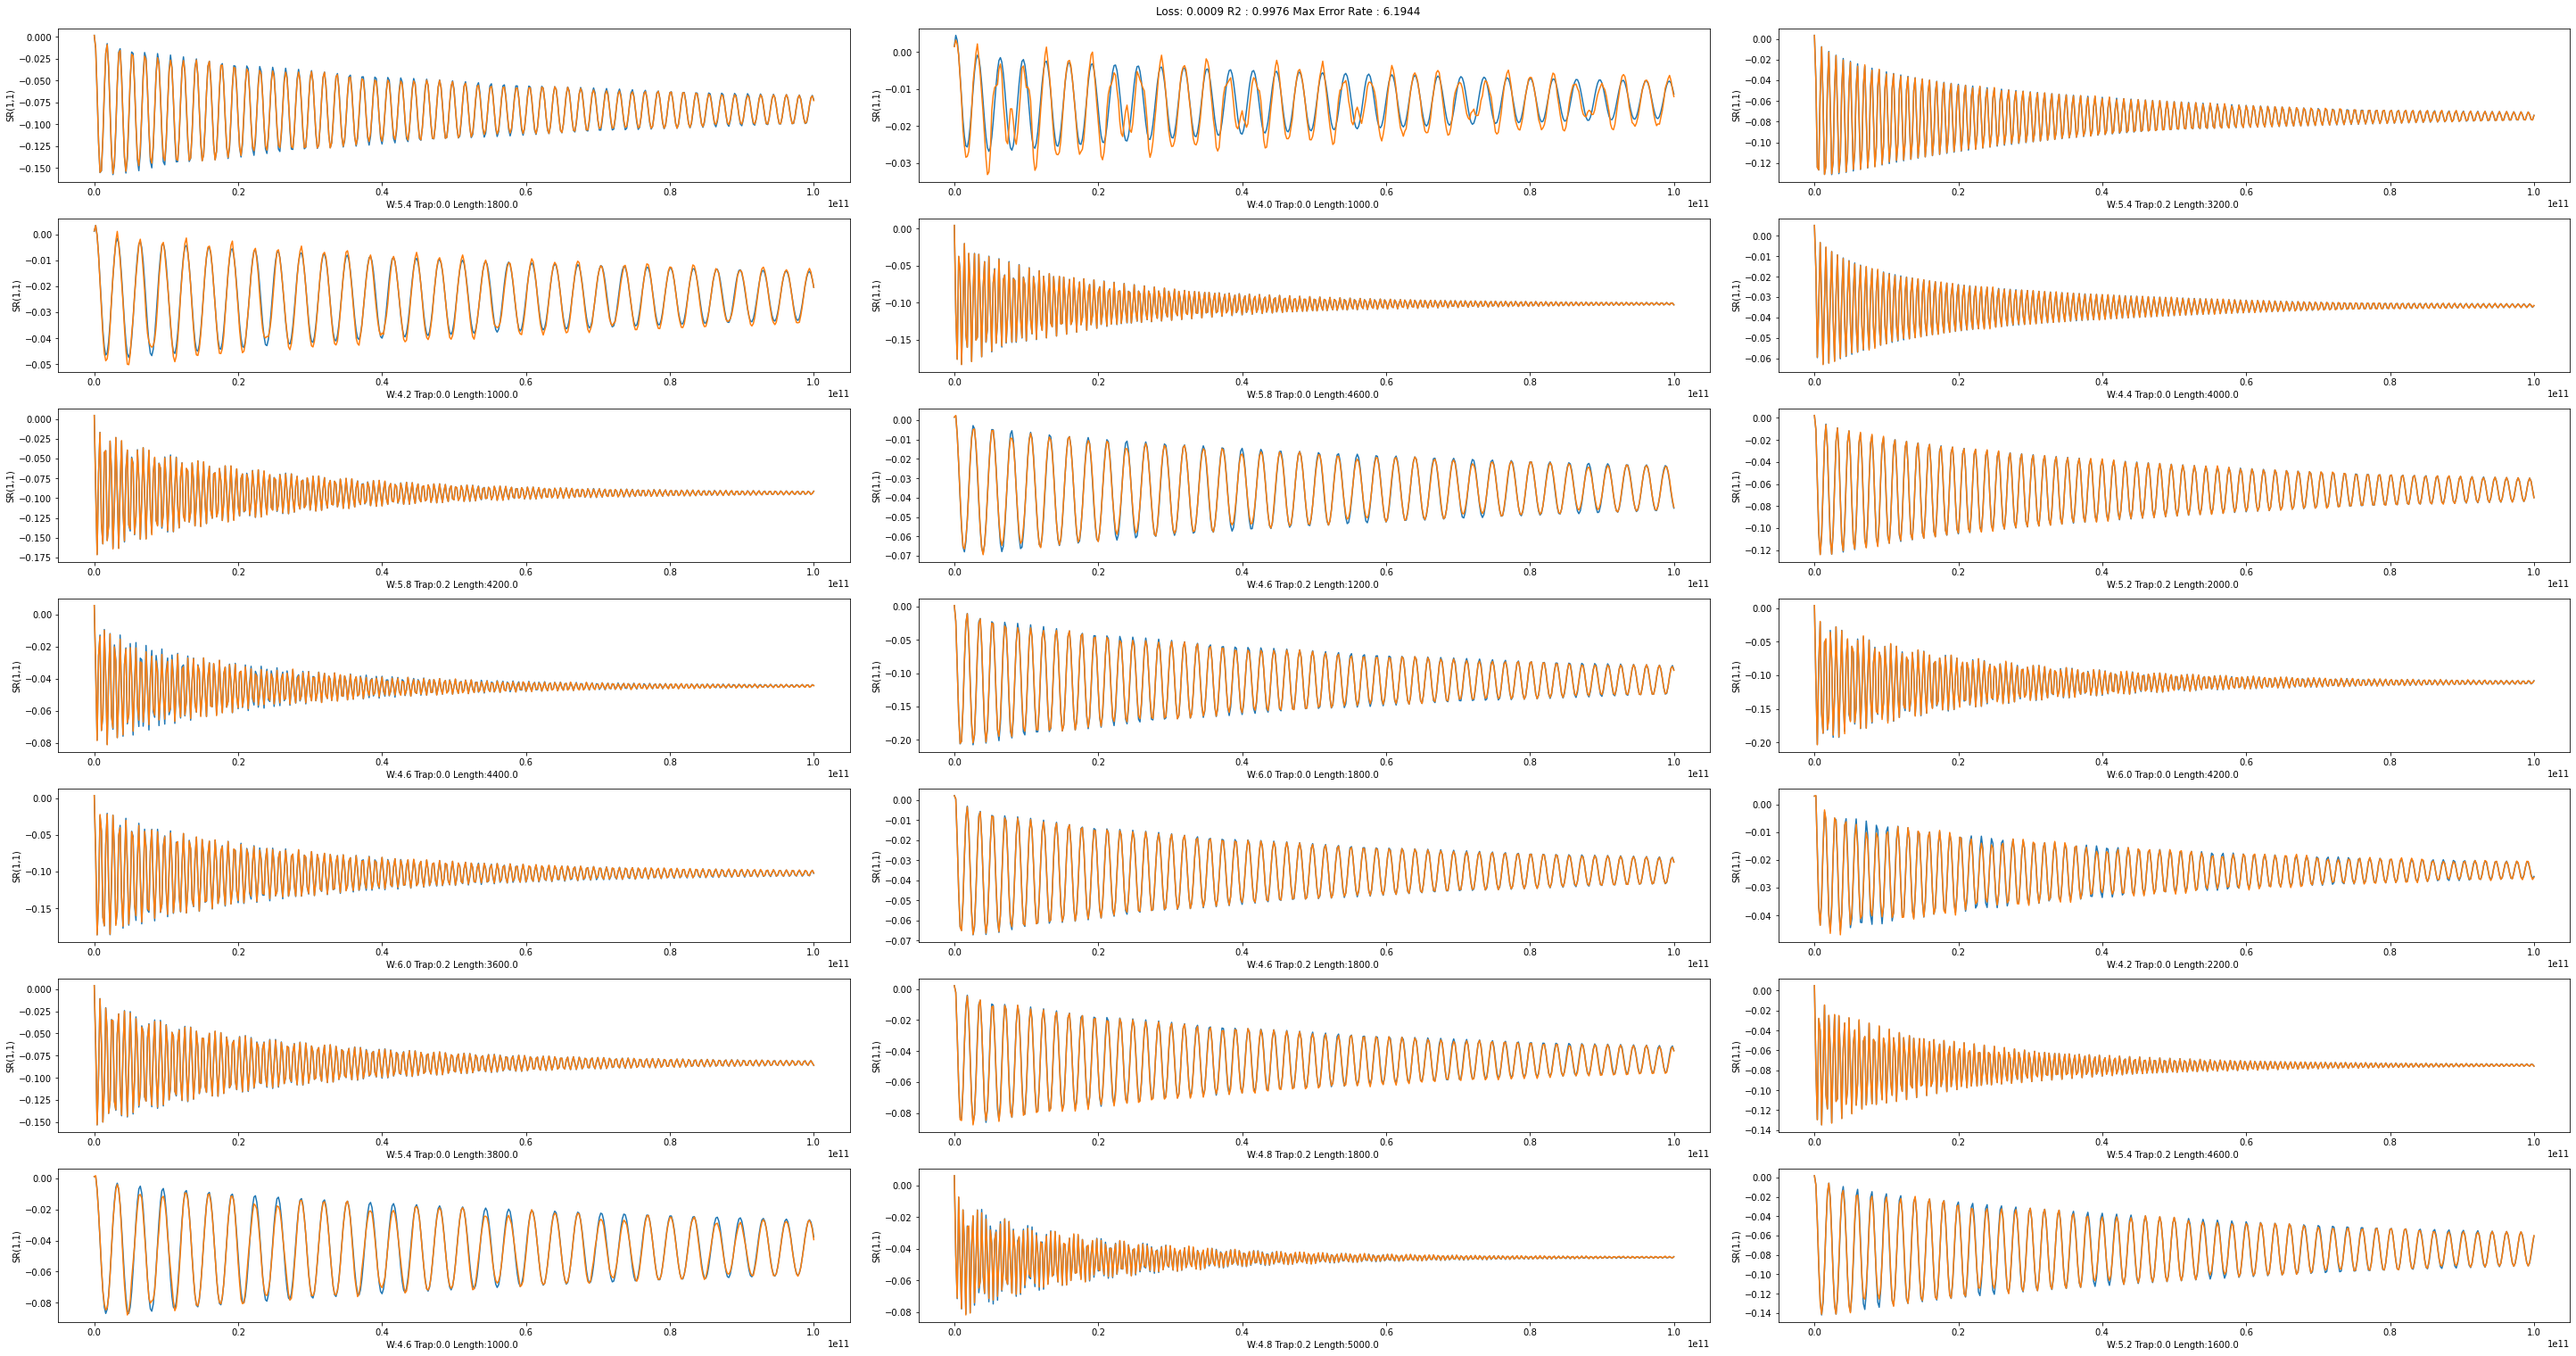

In [12]:
#SR(1,1)

criterion = nn.L1Loss()
predictions['SR(1,1)'] = predictions['A(1,1)'] * torch.cos(predictions['P(1,1)'])
y_test = torch.Tensor(df.loc[indices['test_idx']]['SR(1,1)'].to_numpy().reshape(-1, 501)).to(device)

test_loss = criterion(predictions['SR(1,1)'], y_test)
r2 = r2_score(predictions['SR(1,1)'].detach().cpu().numpy(), y_test.detach().cpu().numpy())
mer = torch.nan_to_num(torch.max(torch.abs(predictions['SR(1,1)'] - y_test) / y_test))

plot_X_y(F.cpu(), y_test.cpu(), df, indices['test_idx'], input_cols, 'SR(1,1)', predictions['SR(1,1)'].cpu(), \
         test_loss, r2, mer, figname='SR(1,1)', savefig=True)

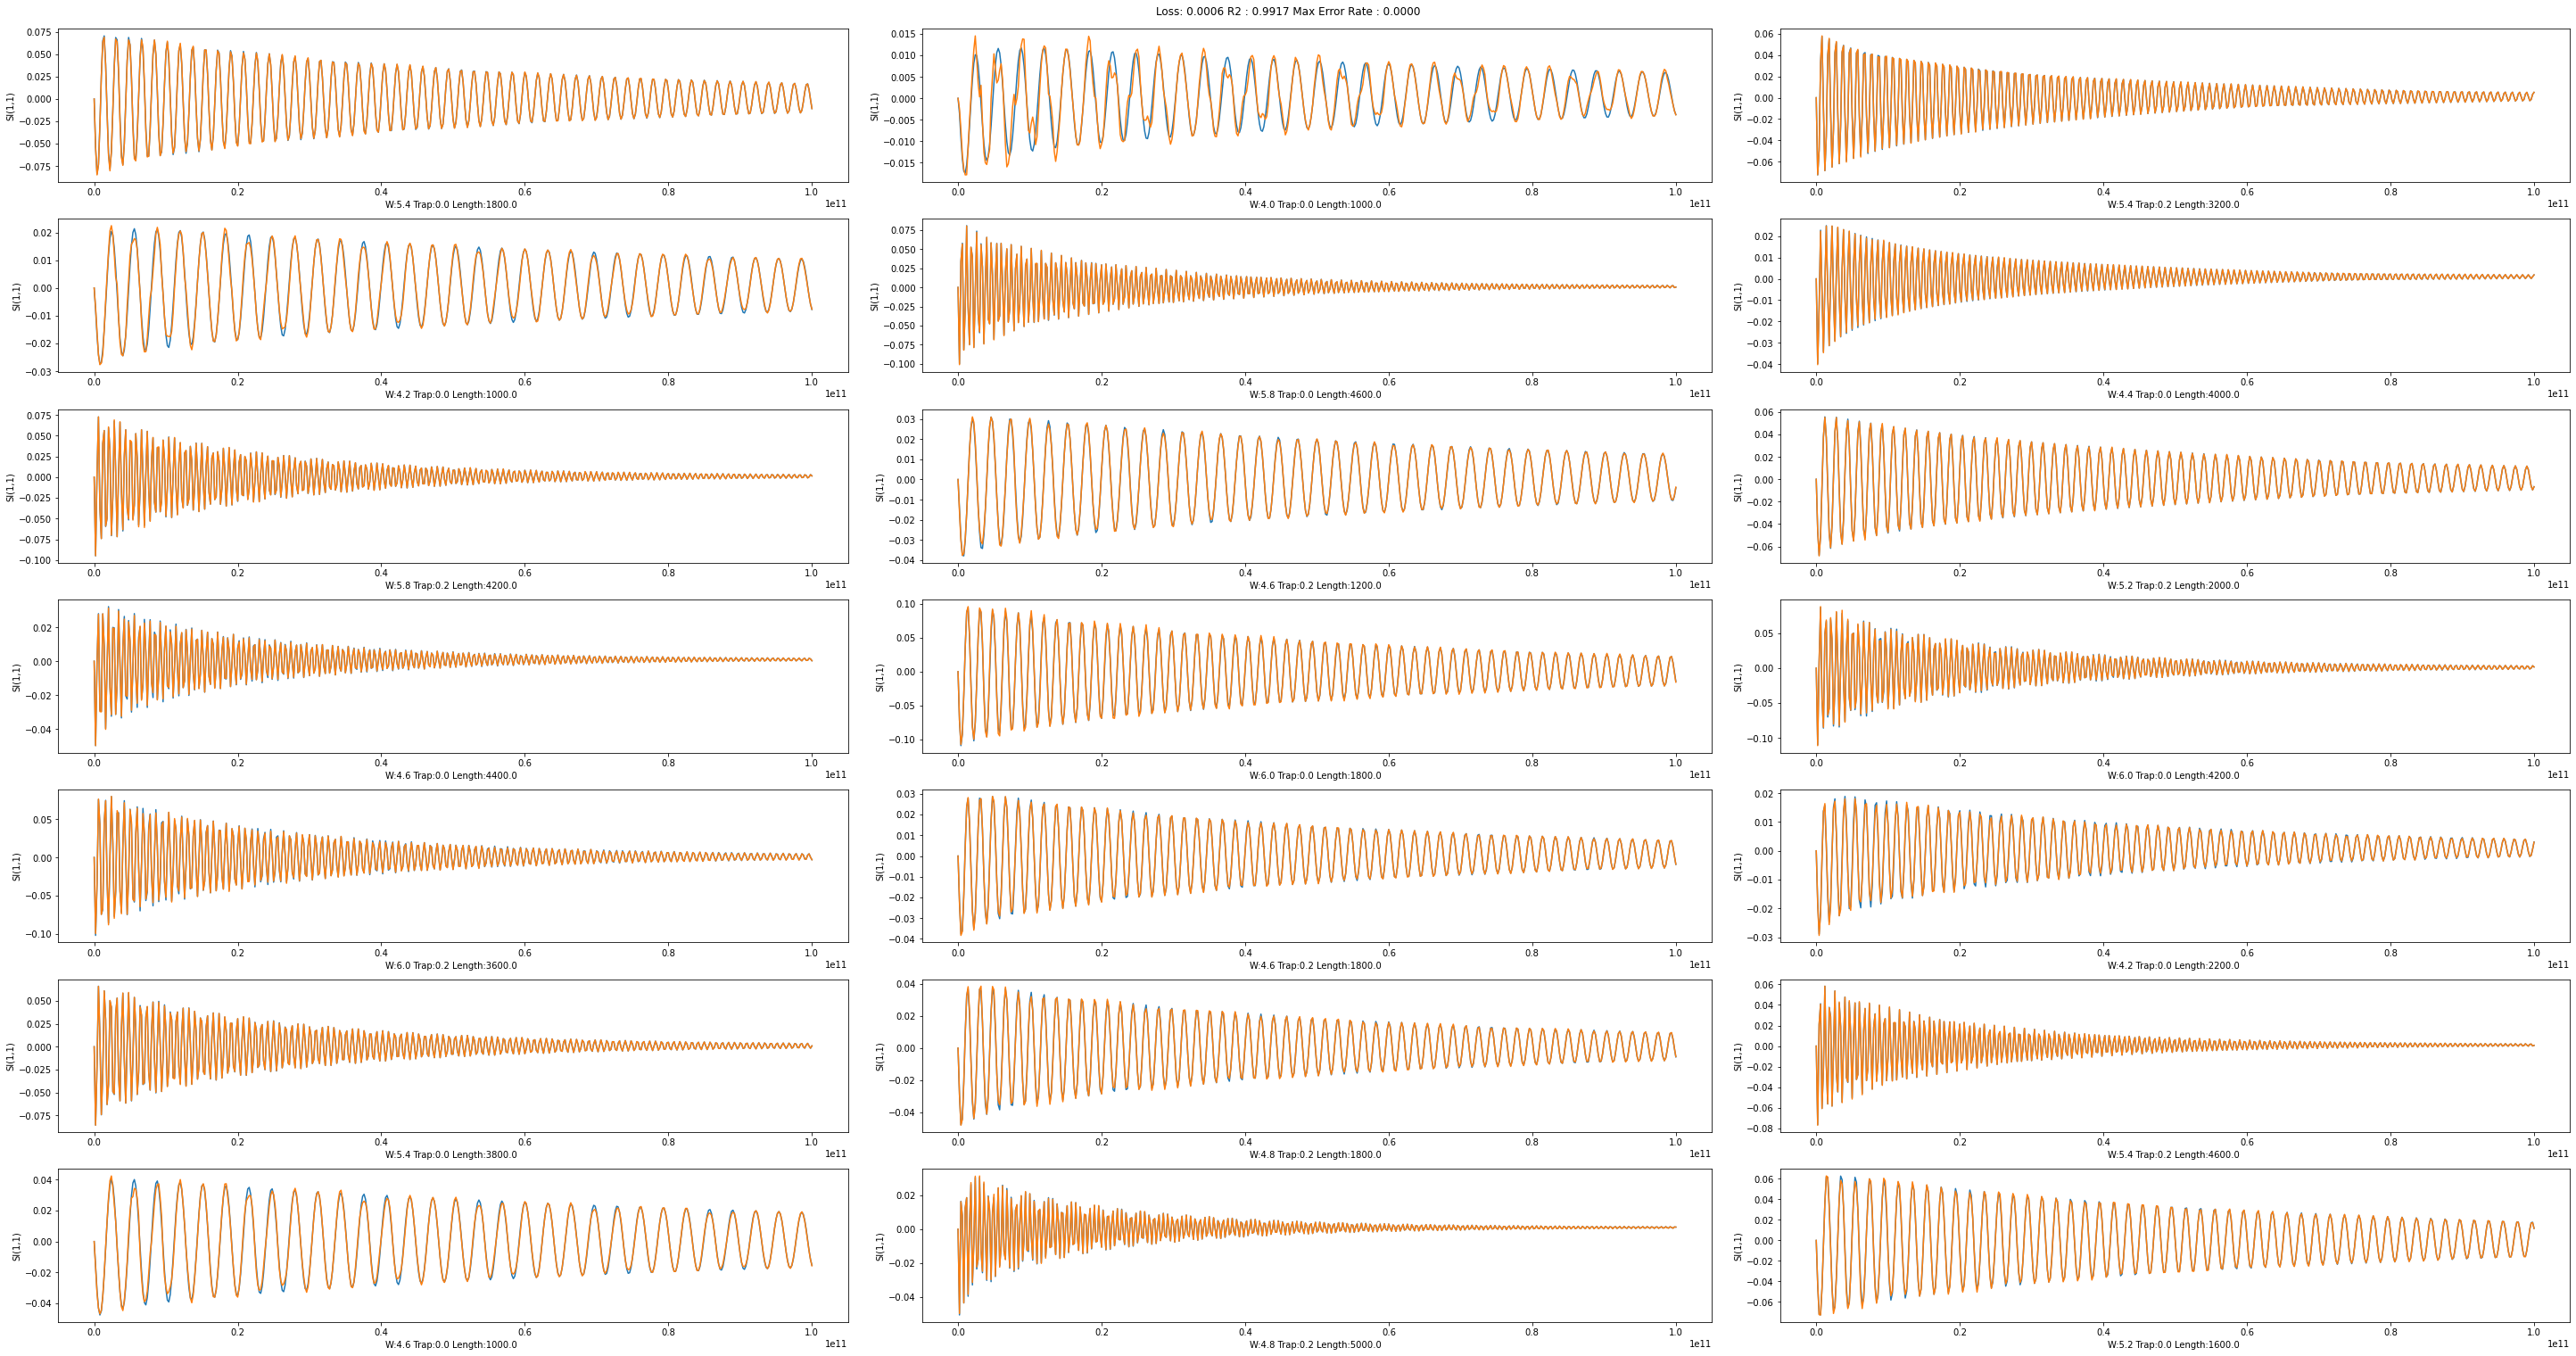

In [13]:
#SI(1,1)

criterion = nn.L1Loss()
predictions['SI(1,1)'] = predictions['A(1,1)'] * torch.sin(predictions['P(1,1)'])
y_test = torch.Tensor(df.loc[indices['test_idx']]['SI(1,1)'].to_numpy().reshape(-1, 501)).to(device)

test_loss = criterion(predictions['SI(1,1)'], y_test)
r2 = r2_score(predictions['SI(1,1)'].detach().cpu().numpy(), y_test.detach().cpu().numpy())
mer = torch.nan_to_num(torch.max(torch.abs(predictions['SI(1,1)'] - y_test) / y_test))

plot_X_y(F.cpu(), y_test.cpu(), df, indices['test_idx'], input_cols, 'SI(1,1)', predictions['SI(1,1)'].cpu(), \
         test_loss, r2, mer, figname='SI(1,1)', savefig=True)

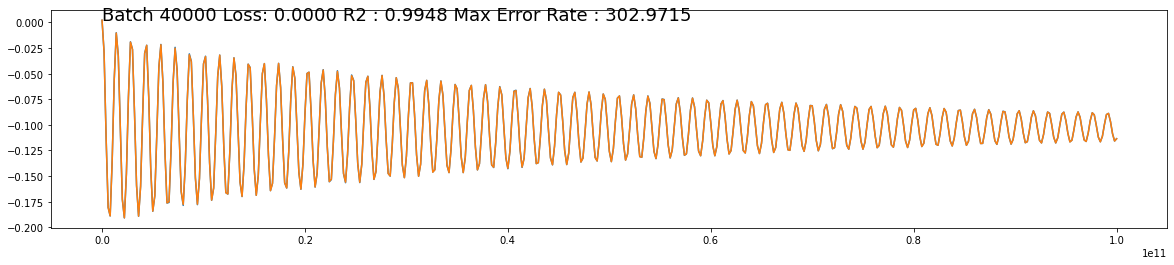

In [16]:
# Direct training SR(1,1)

output_col = 'SR(1,1)'
models[output_col] = MLP.Model(df, indices, input_cols, output_col, in_features, out_features, device)
models[output_col].train(0.001, 40000)

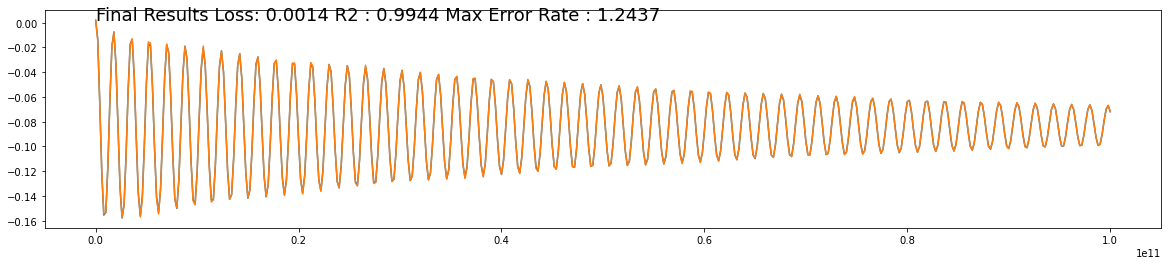

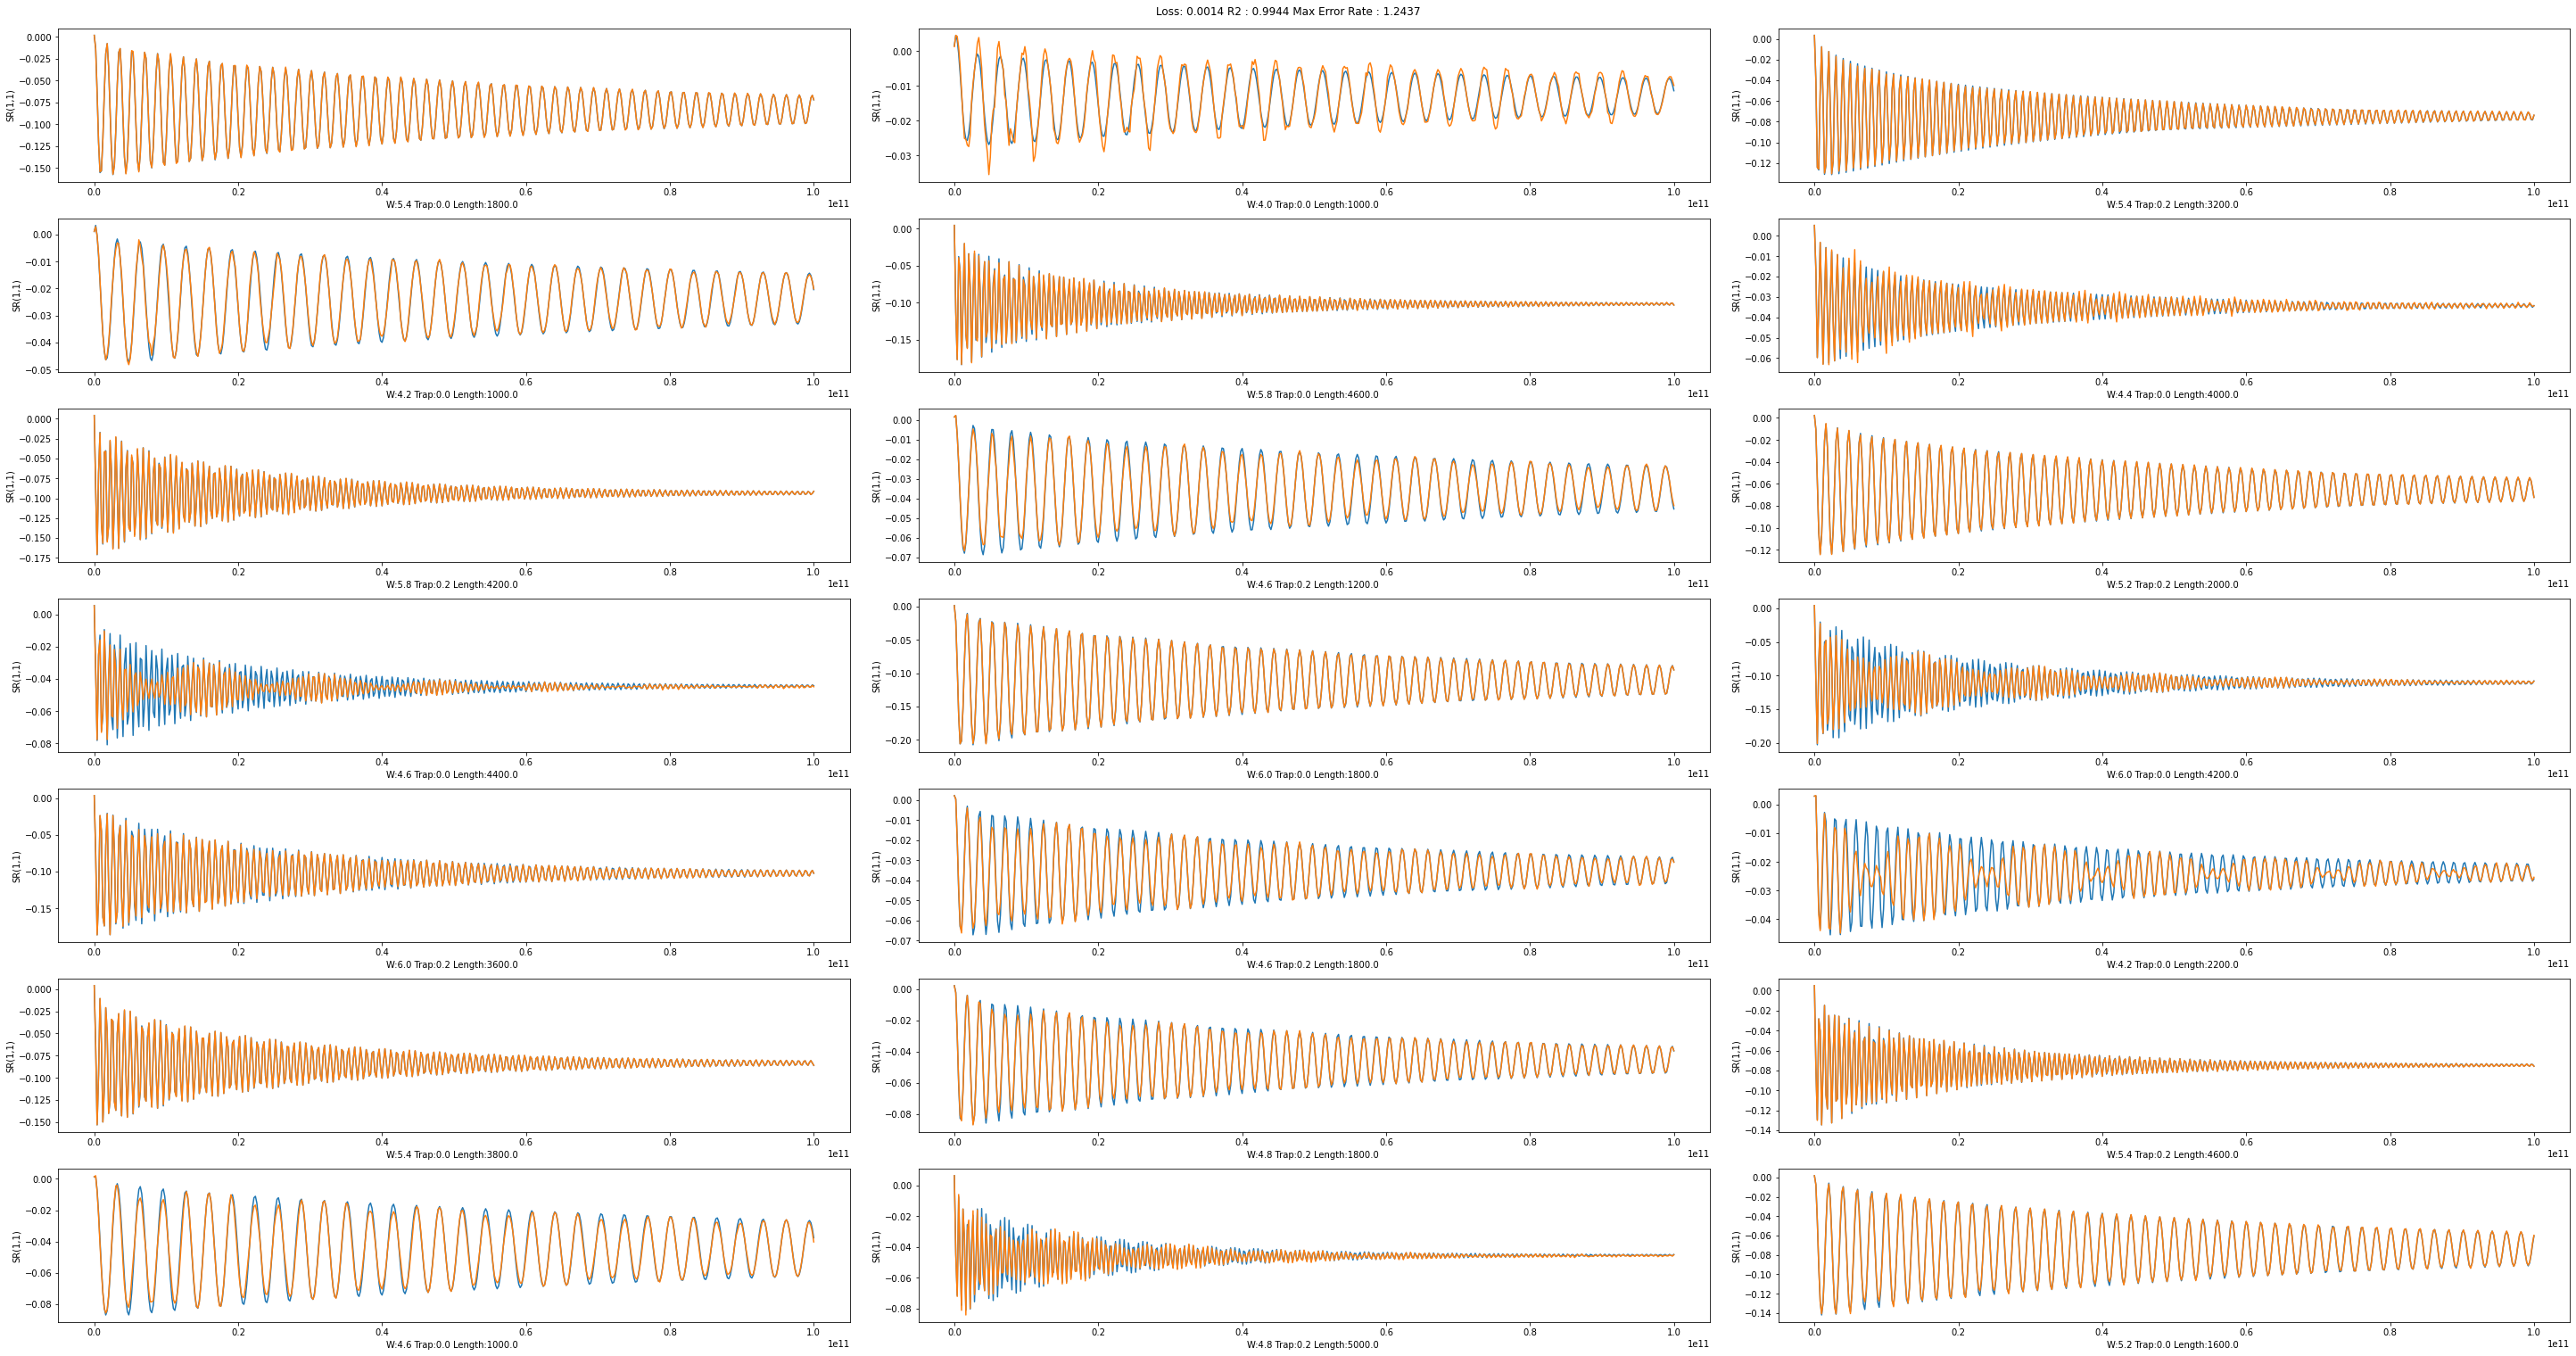

In [17]:
# Direct test SR(1,1)

predictions[output_col] = models[output_col].test()
y_test = torch.Tensor(df.loc[indices['test_idx']]['SR(1,1)'].to_numpy().reshape(-1, 501)).to(device)

test_loss = criterion(predictions['SR(1,1)'], y_test)
r2 = r2_score(predictions['SR(1,1)'].detach().cpu().numpy(), y_test.detach().cpu().numpy())
mer = torch.max(torch.abs(predictions['SR(1,1)'] - y_test) / y_test)

plot_X_y(F.cpu(), y_test.cpu(), df, indices['test_idx'], input_cols, 'SR(1,1)', predictions['SR(1,1)'].cpu(), \
         test_loss, r2, mer, figname='SR(1,1)_direct', savefig=True)

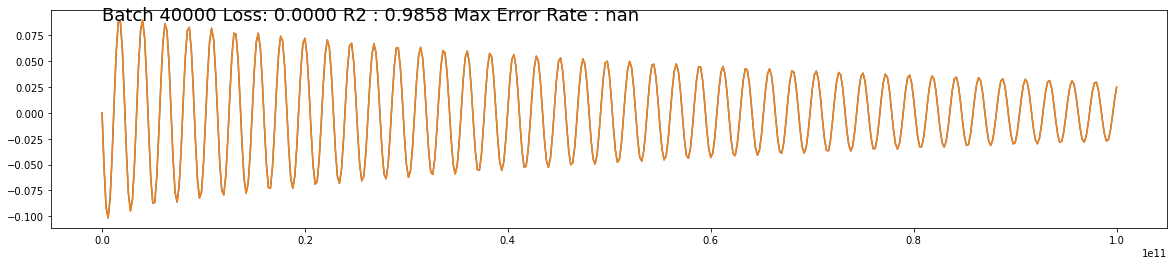

In [18]:
# Direct training SI(1,1)

output_col = 'SI(1,1)'
models[output_col] = MLP.Model(df, indices, input_cols, output_col, in_features, out_features, device)
models[output_col].train(0.001, 40000)

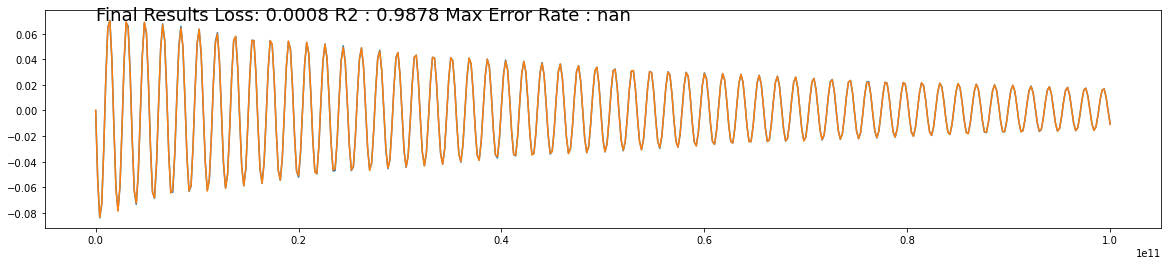

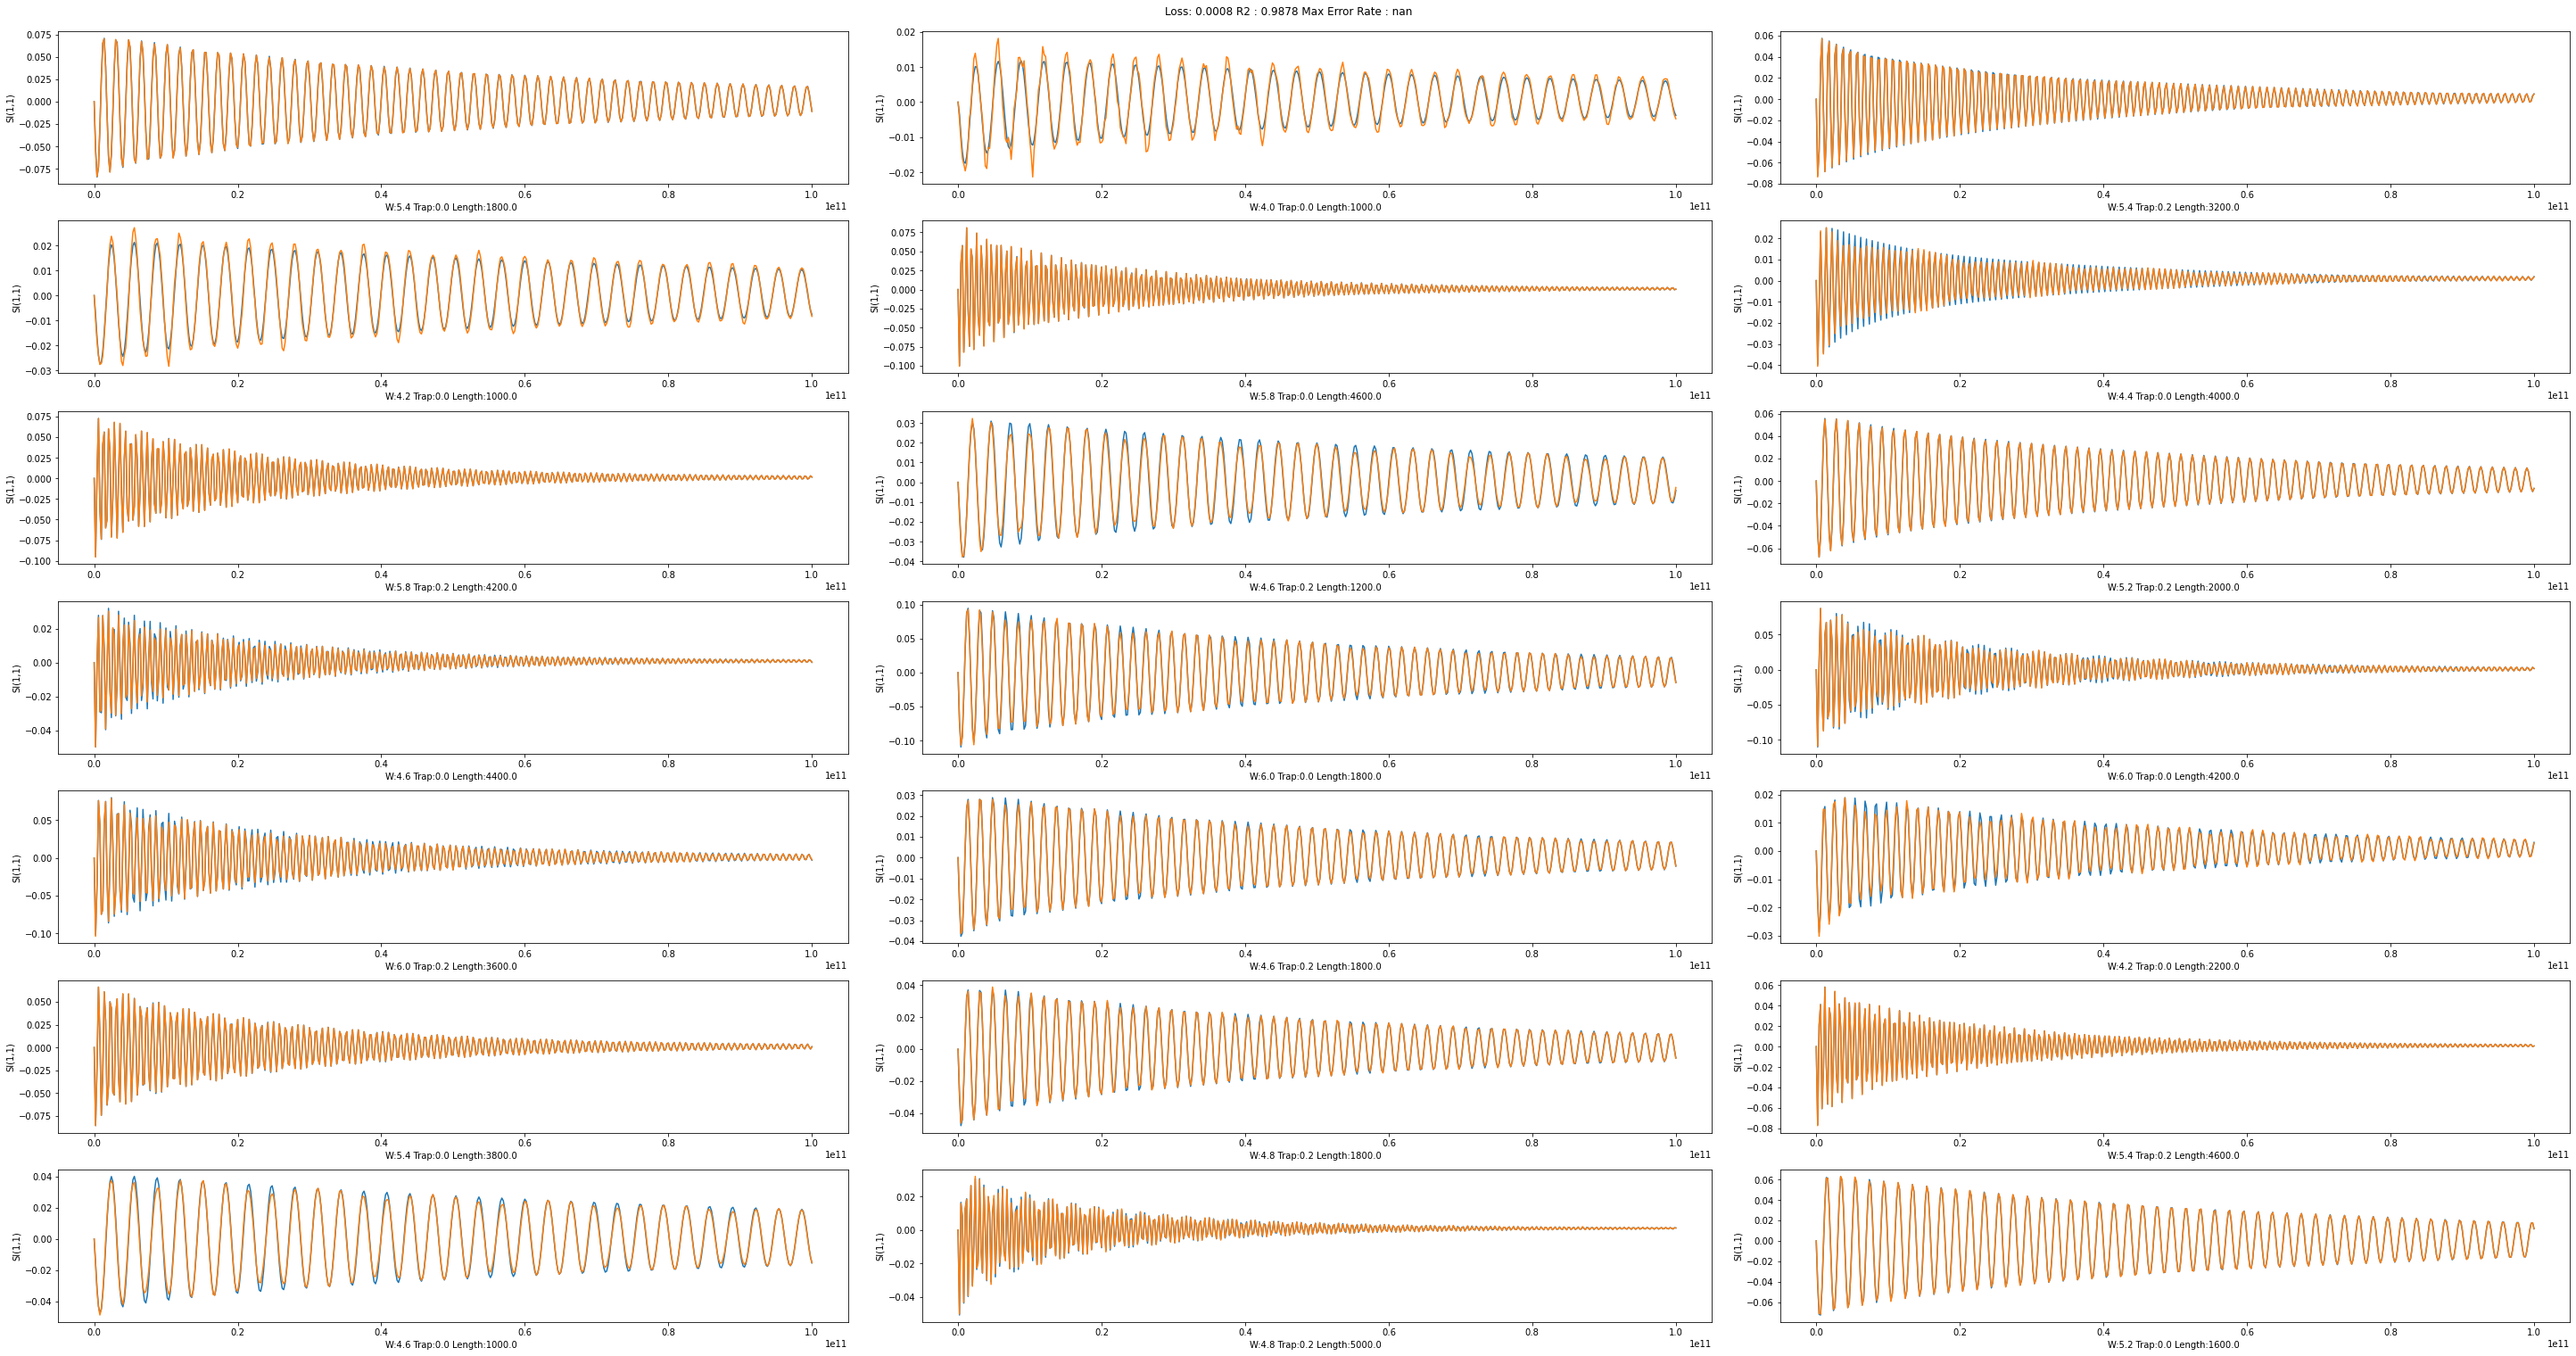

In [19]:
# Direct test SI(1,1)

predictions[output_col] = models[output_col].test()
y_test = torch.Tensor(df.loc[indices['test_idx']]['SI(1,1)'].to_numpy().reshape(-1, 501)).to(device)

test_loss = criterion(predictions['SI(1,1)'], y_test)
r2 = r2_score(predictions['SI(1,1)'].detach().cpu().numpy(), y_test.detach().cpu().numpy())
mer = torch.max(torch.abs(predictions['SI(1,1)'] - y_test) / y_test)

plot_X_y(F.cpu(), y_test.cpu(), df, indices['test_idx'], input_cols, 'SI(1,1)', predictions['SI(1,1)'].cpu(), \
         test_loss, r2, mer, figname='SI(1,1)', savefig=True)

In [20]:
# A(1,1) train prediction

output_col = 'A(1,1)'
_, model, _, _ = models[output_col].load_model()
criterion = nn.L1Loss()
with torch.no_grad():
    predictions['A(1,1)_train'] = model(models[output_col].X_train_norm)
    _, predictions['A(1,1)_train'] = models[output_col].dp.denormalize(y=predictions['A(1,1)_train'])

In [ ]:
# P(1,1) train prediction

output_col = 'P(1,1)'
_, model, _, _ = models[output_col].load_model()
criterion = nn.L1Loss()
with torch.no_grad():
    predictions['P(1,1)_train'] = model(models[output_col].X_train_norm)
    _, predictions['P(1,1)_train'] = models[output_col].dp.denormalize(y=predictions['P(1,1)_train'])

In [ ]:
# Calculate SR(1,1) with training data
predictions['SR(1,1)_train'] = predictions['A(1,1)_train'] * torch.cos(predictions['P(1,1)_train'])
y_train = torch.Tensor(df.loc[indices['train_idx']]['SR(1,1)'].to_numpy().reshape(-1, 501)).to(device)

loss = criterion(predictions['SR(1,1)_train'], y_train)
r2 = r2_score(predictions['SR(1,1)_train'].detach().cpu().numpy(), y_train.detach().cpu().numpy())
mer = torch.max(torch.abs(predictions['SR(1,1)_train'] - y_train) / y_train)

In [ ]:
# Plot SR(1,1) train prediction vs ground truth

plot_X_y_train(F.cpu(), y_train.cpu(), df, indices['train_idx'], input_cols, 'SR(1,1)_train', predictions['SR(1,1)_train'].cpu(), \
               test_loss, r2, mer, figname='SR(1,1)_train', savefig=True)